In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import silhouette_score
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv("train_earth.csv")
test = pd.read_csv("test_earth.csv")
test_gap = pd.read_csv("Gap_Test.csv")
variables = pd.read_csv("VariableDefinitions.csv")

In [3]:
soil_depth = 20
target_columns = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

In [4]:
train_dropna = train.dropna().sort_values(by="PID")
X = train_dropna.drop(columns=target_columns)
Y = train_dropna[target_columns]

In [5]:
def scale_predictions(X, Y_pred):
    scale = X['BulkDensity'].values.reshape(-1, 1) * soil_depth * 0.1
    Y_scaled = Y_pred * scale
    return Y_scaled

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import root_mean_squared_error


def score_predictions(estimator, X, Y_true):
    Y_pred = estimator.predict(X)
    Y_true_final = scale_predictions(X, Y_true)
    Y_pred_final = scale_predictions(X, Y_pred)
    return -root_mean_squared_error(Y_true_final, Y_pred_final)


estimator_last_score = {}


def eval_model(estimator, X, Y, n_splits=5, estimator_key=None, n_jobs=1, print_result=True):
    result = cross_validate(estimator, X, Y, cv=n_splits,
                            scoring=score_predictions, n_jobs=n_jobs)
    scores = -result['test_score']
    mean = np.mean(scores)
    median = np.median(scores)
    if print_result:
        print("mean score:", mean)
        print("median score:", np.median(scores))
        print("std:", np.std(scores))
        print("scores:  ", scores)
    estimator_key = estimator_key or id(estimator)
    if print_result:
        if not estimator_key in estimator_last_score:
            print("first evaluation")
        else:
            last_mean, last_median = estimator_last_score[estimator_key]
            if mean < last_mean:
                print("mean improved")
            elif mean > last_mean:
                print("mean degraded")
            else:
                print("same mean")

            if median < last_median:
                print("median improved")
            elif median > last_median:
                print("median degraded")
            else:
                print("same median")

    estimator_last_score[estimator_key] = (mean, median)
    return result

In [7]:
def eval_classifier(classifier, X, y, n_splits=5, n_jobs=1, print_result=True):
    result = cross_validate(classifier, X, y, cv=n_splits,
                            scoring='f1', n_jobs=n_jobs)
    scores = result['test_score']
    if print_result:
        print("mean score:", np.mean(scores))
        print("median score:", np.median(scores))
        print("std:", np.std(scores))
        print("scores:  ", scores)
    return result

In [8]:
def predict(model, test):
    predictions = model.predict(test)
    predictions = scale_predictions(test, predictions)
    predictions = pd.DataFrame(
        predictions, columns=target_columns, index=test.index)
    predictions["PID"] = test["PID"]
    predictions = predictions.melt(
        id_vars=['PID'], var_name='Nutrient', value_name='Available')
    predictions = predictions.merge(right=test_gap, on=["PID", "Nutrient"])
    predictions["Gap"] = predictions["Required"] - predictions["Available"]
    predictions['ID'] = predictions['PID'] + "_" + predictions['Nutrient']
    predictions = predictions[["ID", "Gap"]]
    return predictions

In [9]:
def add_cluster(X: pd.DataFrame, n_clusters=2) -> pd.DataFrame:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    X = X.copy()
    cluster_labels = kmeans.fit_predict(X)
    X["cluster"] = cluster_labels
    return X

In [10]:
X.columns

Index(['site', 'PID', 'lon', 'lat', 'pH', 'alb', 'bio1', 'bio12', 'bio15',
       'bio7', 'bp', 'cec20', 'dows', 'ecec20', 'hp20', 'ls', 'lstd', 'lstn',
       'mb1', 'mb2', 'mb3', 'mb7', 'mdem', 'para', 'parv', 'ph20', 'slope',
       'snd20', 'soc20', 'tim', 'wp', 'xhp20', 'BulkDensity', 'QA_PIXEL',
       'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
       'SR_B7', 'ST_B10', 'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2',
       'Nadir_Reflectance_Band3', 'Nadir_Reflectance_Band4', 'sur_refl_b01',
       'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05',
       'sur_refl_b06', 'sur_refl_b07', 'LST_Day_1km', 'LST_Night_1km', 'EVI',
       'NDVI', 'RelativeAzimuth', 'SolarZenith', 'ViewZenith',
       'sur_refl_b01.1', 'sur_refl_b02.1', 'sur_refl_b03.1', 'sur_refl_b07.1',
       'ET', 'PET', 'VH', 'VV', 'relativeOrbitNumber_start', 'B1', 'B11',
       'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'CLOUDY_PIXEL_PERCENTAGE'

In [11]:
drop_step = ("drop", FunctionTransformer(
    lambda x: x.drop(columns=["PID", "site", 'Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band4', 'QA_RADSAT',
                              'SENSING_ORBIT_NUMBER', 'SR_B1', 'SR_B2', 'SR_B4', 'SR_B6', 'SolarZenith', 'ecec20',
                              'lstn', 'para', 'relativeOrbitNumber_start', 'sur_refl_b07', 'tim'])))
cluster_step = ("cluster", FunctionTransformer(lambda x: add_cluster(x, 3)))

In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor


from sklearn.multioutput import MultiOutputRegressor
hist = Pipeline([drop_step, ("hist", MultiOutputRegressor(
    TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=0,
                                                                       max_iter=300,
                                                                       learning_rate=0.1,
                                                                       loss='squared_error'),
                               transformer=StandardScaler()),
    n_jobs=2))])
eval_model(hist, X, Y, n_jobs=4, n_splits=4, estimator_key="hist")

mean score: 607.474722514331
median score: 605.481782158141
std: 11.69782697846706
scores:   [605.22814626 605.73541806 593.16826539 625.76706035]
first evaluation


{'fit_time': array([74.12961221, 73.81744742, 74.46955085, 74.40041947]),
 'score_time': array([0.44125748, 0.45638728, 0.39780188, 0.4409461 ]),
 'test_score': array([-605.22814626, -605.73541806, -593.16826539, -625.76706035])}

In [14]:
train_t = train_dropna.drop(columns=target_columns)
values = train_dropna[target_columns]
values = pd.DataFrame(columns=values.columns,
                      data=StandardScaler().fit_transform(values))
train_t["max"] = train_dropna[target_columns].apply(lambda x: np.argmax(
    x), axis=1).map(lambda x: target_columns[x])
train_t.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,Nadir_Reflectance_Band1,Nadir_Reflectance_Band2,Nadir_Reflectance_Band3,Nadir_Reflectance_Band4,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,LST_Day_1km,LST_Night_1km,EVI,NDVI,RelativeAzimuth,SolarZenith,ViewZenith,sur_refl_b01.1,sur_refl_b02.1,sur_refl_b03.1,sur_refl_b07.1,ET,PET,VH,VV,relativeOrbitNumber_start,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,CLOUDY_PIXEL_PERCENTAGE,MEAN_SOLAR_ZENITH_ANGLE,NODATA_PIXEL_PERCENTAGE,SENSING_ORBIT_NUMBER,max
5570,site_id_fHKoVt,ID_00JFdR,71.425333,40.792510,7.5,140,166,1007,105,157,0.218016,39.00,14.546627,41.080200,0.0802,1.381701,33.766338,9.997397,942.999756,2658.998291,528.999939,1491.999756,2257,33.814816,229.046478,6.4,4.011909,23.00,20.75,11.462457,0.020814,0.001952,1.21,24042.614182,0.0,0.132869,0.146911,0.182124,0.195454,0.367217,0.303369,0.215204,1.005461,0.141500,0.272578,0.071342,0.113250,0.143733,0.291179,0.092857,0.130097,0.302910,0.249518,0.159438,302.811112,284.826075,0.209349,0.333970,0.317428,0.323221,0.150444,0.130327,0.259321,0.065906,0.168478,8.857431,47.514734,-26.200324,-13.944251,79.000000,431.223047,2142.193286,1622.879160,721.561436,985.551327,1229.794490,1469.492957,1802.205915,1949.941767,2046.952463,2125.135941,2158.765681,5.083326,36.572756,79.087483,135.0,Ca
3618,site_id_B2TQun,ID_00dHFD,69.558407,43.188127,5.2,140,184,1468,106,163,0.715179,41.25,2.061439,29.260000,2.2600,0.030000,34.433472,11.595396,783.000793,2634.998535,420.000061,1314.000610,1986,35.194847,427.560822,5.8,1.053306,22.00,24.75,9.908129,0.015821,0.077239,1.17,26454.681132,0.0,0.091589,0.097920,0.122330,0.126524,0.317155,0.187963,0.128917,0.984652,0.095832,0.263150,0.041669,0.075539,0.109862,0.294618,0.062611,0.095706,0.302540,0.237461,0.139316,303.781782,285.271531,0.277616,0.481934,0.403028,0.334905,0.134106,0.088163,0.251561,0.039063,0.133680,14.092711,45.053569,-15.389731,-10.903230,97.248772,224.533229,2461.727364,1880.928648,501.169096,775.769297,1053.152708,1330.678516,1794.987683,2012.997607,2112.170730,2219.866695,2209.574028,0.380745,40.104047,0.000000,135.0,N
6048,site_id_wc31Vr,ID_00de4K,71.302885,40.781527,6.4,146,165,963,91,155,0.211083,44.50,5.550591,41.015999,0.0160,0.238472,34.404427,9.639873,1029.999634,2270.999512,551.999939,1488.999878,2304,27.001610,263.964569,6.7,2.143312,29.25,11.50,14.486402,0.015068,0.000390,1.40,23642.596634,0.0,0.138997,0.154024,0.188630,0.205959,0.309026,0.261623,0.192272,1.004303,0.136091,0.254960,0.067146,0.107457,0.192870,0.301509,0.135443,0.168892,0.322550,0.277324,0.183053,301.888136,284.166821,0.196681,0.326268,0.337461,0.330761,0.172765,0.125181,0.245062,0.063053,0.153540,9.147973,43.364881,-20.055792,-12.923051,79.000000,431.426270,2143.102546,1623.821380,721.924323,985.940897,1230.230302,1469.814983,1802.307879,1949.944985,2046.819205,2125.246747,2159.020797,5.072059,36.572421,79.119055,135.0,Ca
6134,site_id_lOHgPZ,ID_01fM6d,71.015592,40.543619,7.6,123,186,944,85,154,0.143649,51.25,8.309956,40.000000,0.0000,0.095159,37.985703,11.249413,904.000122,1951.000122,446.000061,1373.000122,1908,24.663446,306.818085,7.1,0.795970,21.00,11.00,11.349622,0.015479,0.000000,1.40,24528.296448,0.0,0.162824,0.175132,0.198753,0.209053,0.300468,0.253934,0.193340,1.010731,0.111309,0.209360,0.057839,0.089576,0.209184,0.305233,0.163756,0.191543,0.328159,0.295560,0.207255,307.641071,285.856038,0.171507,0.310363,0.219592,0.329121,0.172354,0.109854,0.209321,0.057441,0.157189,11.251168,48.436636,-18.130688,-10.660047,79.000000,804.219333,2618.740941,2083.163916,1068.001431,1280.578735,1533.189561,1757.708263,1942.967230,2089.775178,2159.041115,2297.809282,2313.131767,13.310374,33.138427,83.134583,135.0,Ca
4196,site_id_wwv9Ou,ID_01qDuZ,70.304951,41.107159,4.9,156,136,1603,104,151,0.818698,42.50

In [15]:
(train_t['max'] == "Ca").mean()

np.float64(0.8010342598577893)

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_t["max"])
clf = Pipeline(
    [("drop", FunctionTransformer(lambda x: x.drop(columns=["PID", "site"]))),
     ("scale", StandardScaler()),
     ("pca", PCA(73)),
     ("log", LogisticRegressionCV(
         random_state=0,
         solver='sag',
         n_jobs=-1
     ))])
eval_classifier(clf, train_t.drop(
    columns=["max"]), y_encoded, n_jobs=-1, n_splits=4)

mean score: 0.7668235293230559
median score: 0.7715054240718712
std: 0.011304735945014835
scores:   [0.77479893 0.77631579 0.76821192 0.74796748]


{'fit_time': array([13.27521658, 13.17175865, 13.15929437, 13.33670259]),
 'score_time': array([0.01079631, 0.0112133 , 0.01524067, 0.00945973]),
 'test_score': array([0.77479893, 0.77631579, 0.76821192, 0.74796748])}

In [90]:
train[['MEAN_SOLAR_ZENITH_ANGLE', 'NODATA_PIXEL_PERCENTAGE',
       'RelativeAzimuth', 'SENSING_ORBIT_NUMBER', 'VH', 'VV', 'dows',
       'lstd', 'para', 'relativeOrbitNumber_start']] < 0

,MEAN_SOLAR_ZENITH_ANGLE,NODATA_PIXEL_PERCENTAGE,RelativeAzimuth,SENSING_ORBIT_NUMBER,VH,VV,dows,lstd,para,relativeOrbitNumber_start
0,False,False,False,False,True,True,False,False,False,False
1,False,False,False,False,True,True,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False
3,False,False,False,False,True,True,False,False,False,False
4,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
7739,False,False,False,False,True,True,False,False,False,False
7740,False,False,False,False,True,True,False,False,False,False
7741,False,False,False,False,True,True,False,False,False,False
7742,False,False,False,False,True,True,False,False,False,False


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_t["max"])
clf = Pipeline(
    [("drop", FunctionTransformer(lambda x: x.drop(columns=["PID", "site"]))),
     ("c", ColumnTransformer(
         [('log', 'passthrough', ['pH']),],
         remainder='passthrough')),
     ("hist", HistGradientBoostingClassifier())])
eval_classifier(clf, train_t.drop(
    columns=["max"]), y_encoded, n_jobs=-1, n_splits=4)

mean score: 0.7894261497289808
median score: 0.7892642747452185
std: 0.012910745279900488
scores:   [0.77173913 0.80743692 0.79310345 0.7854251 ]


{'fit_time': array([3.32609129, 3.34014082, 3.32623076, 3.32563877]),
 'score_time': array([0.03889346, 0.03969407, 0.04218554, 0.04471397]),
 'test_score': array([0.77173913, 0.80743692, 0.79310345, 0.7854251 ])}

In [93]:
cols = train_t.select_dtypes('number').columns

A = ColumnTransformer(
    [('log_transform', FunctionTransformer(lambda x: np.abs(np.log1p(x))),
      np.setdiff1d(cols, skip))],
    remainder='passthrough'
).fit_transform(train_t[cols])

B = ColumnTransformer(
    [('skip_passthrough', 'passthrough', skip)],
    remainder=FunctionTransformer(lambda x: np.abs(np.log1p(x)))
).fit_transform(train_t[cols])

df_A = pd.DataFrame(A, columns=np.append(np.setdiff1d(cols, skip), skip))
df_B = pd.DataFrame(B, columns=np.append(skip, np.setdiff1d(cols, skip)))

# Align columns before subtraction
df_A = df_A[df_B.columns]

# Now you can compare:
diff = df_A - df_B
diff

c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,ecec20,hp20,ls,lstn,mb1,mb2,mb3,mb7,mdem,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,Nadir_Reflectance_Band1,Nadir_Reflectance_Band2,Nadir_Reflectance_Band3,Nadir_Reflectance_Band4,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,LST_Day_1km,LST_Night_1km,EVI,NDVI,SolarZenith,ViewZenith,sur_refl_b01.1,sur_refl_b02.1,sur_refl_b03.1,sur_refl_b07.1,ET,PET,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,CLOUDY_PIXEL_PERCENTAGE,MEAN_SOLAR_ZENITH_ANGLE,NODATA_PIXEL_PERCENTAGE,RelativeAzimuth,SENSING_ORBIT_NUMBER,VH,VV,dows,lstd,para,relativeOrbitNumber_start
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882436,0.834470,-3.274362,4.636974,NaN,NaN,-1.638183,-0.077630,-0.833077,-0.530628
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.597222,-3.567657,-3.250284,4.574022,NaN,NaN,-3.468618,-0.148450,3.588917,-0.325152
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.746715,0.816677,-3.041489,4.621882,NaN,NaN,-2.502471,-0.059433,-1.051252,-0.530628
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.299339,0.769223,-3.046551,4.714139,NaN,NaN,-2.150942,0.132771,-1.187350,-0.530628
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294275,-3.277049,-3.333499,4.679188,NaN,NaN,-2.090088,0.042423,3.566967,0.117783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411875,0.770833,-3.336694,4.801793,NaN,NaN,-1.151821,-0.104933,-0.860425,-0.530628
7731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.935924,-3.480775,-3.496984,4.822370,NaN,NaN,-2.731737,0.246149,3.587269,0.117783
7732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [73]:
np.setdiff1d(train_t.select_dtypes(include='number').columns, skip)

array(['MEAN_SOLAR_ZENITH_ANGLE', 'NODATA_PIXEL_PERCENTAGE',
       'RelativeAzimuth', 'SENSING_ORBIT_NUMBER', 'VH', 'VV', 'dows',
       'lstd', 'para', 'relativeOrbitNumber_start'], dtype=object)

In [74]:
skip

['lon',
 'lat',
 'pH',
 'alb',
 'bio1',
 'bio12',
 'bio15',
 'bio7',
 'bp',
 'cec20',
 'ecec20',
 'hp20',
 'ls',
 'lstn',
 'mb1',
 'mb2',
 'mb3',
 'mb7',
 'mdem',
 'parv',
 'ph20',
 'slope',
 'snd20',
 'soc20',
 'tim',
 'wp',
 'xhp20',
 'BulkDensity',
 'QA_PIXEL',
 'QA_RADSAT',
 'SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'ST_B10',
 'Nadir_Reflectance_Band1',
 'Nadir_Reflectance_Band2',
 'Nadir_Reflectance_Band3',
 'Nadir_Reflectance_Band4',
 'sur_refl_b01',
 'sur_refl_b02',
 'sur_refl_b03',
 'sur_refl_b04',
 'sur_refl_b05',
 'sur_refl_b06',
 'sur_refl_b07',
 'LST_Day_1km',
 'LST_Night_1km',
 'EVI',
 'NDVI',
 'SolarZenith',
 'ViewZenith',
 'sur_refl_b01.1',
 'sur_refl_b02.1',
 'sur_refl_b03.1',
 'sur_refl_b07.1',
 'ET',
 'PET',
 'B1',
 'B11',
 'B12',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'CLOUDY_PIXEL_PERCENTAGE']

In [56]:
skip = []
base = 0.7975856348887865
for col in tqdm(train_t.select_dtypes(include='number').columns):
    clf = Pipeline(
        [("drop", FunctionTransformer(lambda x: x.drop(columns=["PID", "site"]))),
         ("c", ColumnTransformer(
             [('identity', 'passthrough', [col]),],
             remainder=FunctionTransformer(np.log))),
            ("hist", HistGradientBoostingClassifier())])
    r = eval_classifier(clf, train_t.drop(
        columns=["max"]), y_encoded, n_jobs=-1, n_splits=4, print_result=False)
    score = np.mean(r['test_score'])
    print("score:", score)
    if score >= base:
        skip.append(col)
        print(f"{col} should be passed through")
        if (score > base):
            print("improved")
    else:
        print(f"{col} should be log transformed")

  1%|          | 1/84 [00:06<08:33,  6.19s/it]

score: 0.7975856348887865
lon should be passed through


  2%|▏         | 2/84 [00:10<07:11,  5.26s/it]

score: 0.7975856348887865
lat should be passed through


  4%|▎         | 3/84 [00:15<06:36,  4.89s/it]

score: 0.7975856348887865
pH should be passed through


  5%|▍         | 4/84 [00:17<05:18,  3.98s/it]

score: 0.7975856348887865
alb should be passed through


  6%|▌         | 5/84 [00:20<04:38,  3.53s/it]

score: 0.7975856348887865
bio1 should be passed through


  7%|▋         | 6/84 [00:23<04:10,  3.21s/it]

score: 0.7975856348887865
bio12 should be passed through


  8%|▊         | 7/84 [00:25<03:48,  2.97s/it]

score: 0.7975856348887865
bio15 should be passed through


 10%|▉         | 8/84 [00:28<03:39,  2.89s/it]

score: 0.7975856348887865
bio7 should be passed through


 11%|█         | 9/84 [00:30<03:27,  2.77s/it]

score: 0.7975856348887865
bp should be passed through


 12%|█▏        | 10/84 [00:33<03:13,  2.62s/it]

score: 0.7975856348887865
cec20 should be passed through


 13%|█▎        | 11/84 [00:35<03:06,  2.56s/it]

score: 0.7950467887677174
dows should be log transformed


 14%|█▍        | 12/84 [00:37<02:58,  2.48s/it]

score: 0.7975856348887865
ecec20 should be passed through


 15%|█▌        | 13/84 [00:40<02:54,  2.46s/it]

score: 0.7975856348887865
hp20 should be passed through


 17%|█▋        | 14/84 [00:42<02:47,  2.40s/it]

score: 0.7975856348887865
ls should be passed through


 18%|█▊        | 15/84 [00:44<02:42,  2.35s/it]

score: 0.7971916238564777
lstd should be log transformed


 19%|█▉        | 16/84 [00:47<02:46,  2.45s/it]

score: 0.7975856348887865
lstn should be passed through


 20%|██        | 17/84 [00:49<02:45,  2.47s/it]

score: 0.7975856348887865
mb1 should be passed through


 21%|██▏       | 18/84 [00:52<02:45,  2.50s/it]

score: 0.7975856348887865
mb2 should be passed through


 23%|██▎       | 19/84 [00:55<02:44,  2.53s/it]

score: 0.7975856348887865
mb3 should be passed through


 24%|██▍       | 20/84 [00:57<02:42,  2.54s/it]

score: 0.7975856348887865
mb7 should be passed through


 25%|██▌       | 21/84 [01:00<02:40,  2.55s/it]

score: 0.7975856348887865
mdem should be passed through


 26%|██▌       | 22/84 [01:02<02:36,  2.52s/it]

score: 0.7951684881202052
para should be log transformed


 27%|██▋       | 23/84 [01:05<02:33,  2.52s/it]

score: 0.7975856348887865
parv should be passed through


 29%|██▊       | 24/84 [01:07<02:34,  2.57s/it]

score: 0.7975856348887865
ph20 should be passed through


 30%|██▉       | 25/84 [01:10<02:32,  2.58s/it]

score: 0.7975856348887865
slope should be passed through


 31%|███       | 26/84 [01:13<02:28,  2.55s/it]

score: 0.7975856348887865
snd20 should be passed through


 32%|███▏      | 27/84 [01:15<02:28,  2.60s/it]

score: 0.7975856348887865
soc20 should be passed through


 33%|███▎      | 28/84 [01:18<02:21,  2.53s/it]

score: 0.7975856348887865
tim should be passed through


 35%|███▍      | 29/84 [01:20<02:22,  2.58s/it]

score: 0.7975856348887865
wp should be passed through


 36%|███▌      | 30/84 [01:23<02:15,  2.51s/it]

score: 0.7975856348887865
xhp20 should be passed through


 37%|███▋      | 31/84 [01:25<02:09,  2.44s/it]

score: 0.7975856348887865
BulkDensity should be passed through


 38%|███▊      | 32/84 [01:27<02:04,  2.39s/it]

score: 0.7975856348887865
QA_PIXEL should be passed through


 39%|███▉      | 33/84 [01:30<02:01,  2.38s/it]

score: 0.7975856348887865
QA_RADSAT should be passed through


 40%|████      | 34/84 [01:32<01:56,  2.32s/it]

score: 0.7975856348887865
SR_B1 should be passed through


 42%|████▏     | 35/84 [01:34<01:53,  2.31s/it]

score: 0.7975856348887865
SR_B2 should be passed through


 43%|████▎     | 36/84 [01:36<01:49,  2.28s/it]

score: 0.7975856348887865
SR_B3 should be passed through


 44%|████▍     | 37/84 [01:38<01:46,  2.26s/it]

score: 0.7975856348887865
SR_B4 should be passed through


 45%|████▌     | 38/84 [01:41<01:43,  2.26s/it]

score: 0.7975856348887865
SR_B5 should be passed through


 46%|████▋     | 39/84 [01:43<01:40,  2.24s/it]

score: 0.7975856348887865
SR_B6 should be passed through


 48%|████▊     | 40/84 [01:45<01:37,  2.21s/it]

score: 0.7975856348887865
SR_B7 should be passed through


 49%|████▉     | 41/84 [01:47<01:38,  2.28s/it]

score: 0.7975856348887865
ST_B10 should be passed through


 50%|█████     | 42/84 [01:50<01:35,  2.28s/it]

score: 0.7975856348887865
Nadir_Reflectance_Band1 should be passed through


 51%|█████     | 43/84 [01:52<01:32,  2.26s/it]

score: 0.7975856348887865
Nadir_Reflectance_Band2 should be passed through


 52%|█████▏    | 44/84 [01:54<01:30,  2.26s/it]

score: 0.7975856348887865
Nadir_Reflectance_Band3 should be passed through


 54%|█████▎    | 45/84 [01:56<01:27,  2.25s/it]

score: 0.7975856348887865
Nadir_Reflectance_Band4 should be passed through


 55%|█████▍    | 46/84 [01:59<01:25,  2.24s/it]

score: 0.7975856348887865
sur_refl_b01 should be passed through


 56%|█████▌    | 47/84 [02:01<01:23,  2.25s/it]

score: 0.7975856348887865
sur_refl_b02 should be passed through


 57%|█████▋    | 48/84 [02:03<01:20,  2.23s/it]

score: 0.7975856348887865
sur_refl_b03 should be passed through


 58%|█████▊    | 49/84 [02:05<01:17,  2.22s/it]

score: 0.7975856348887865
sur_refl_b04 should be passed through


 60%|█████▉    | 50/84 [02:08<01:16,  2.24s/it]

score: 0.7975856348887865
sur_refl_b05 should be passed through


 61%|██████    | 51/84 [02:10<01:13,  2.22s/it]

score: 0.7975856348887865
sur_refl_b06 should be passed through


 62%|██████▏   | 52/84 [02:12<01:13,  2.29s/it]

score: 0.7975856348887865
sur_refl_b07 should be passed through


 63%|██████▎   | 53/84 [02:15<01:12,  2.35s/it]

score: 0.7975856348887865
LST_Day_1km should be passed through


 64%|██████▍   | 54/84 [02:17<01:09,  2.31s/it]

score: 0.7975856348887865
LST_Night_1km should be passed through


 65%|██████▌   | 55/84 [02:19<01:07,  2.31s/it]

score: 0.7975856348887865
EVI should be passed through


 67%|██████▋   | 56/84 [02:22<01:05,  2.35s/it]

score: 0.7975856348887865
NDVI should be passed through


 68%|██████▊   | 57/84 [02:24<01:02,  2.33s/it]

score: 0.7973773488560902
RelativeAzimuth should be log transformed


 69%|██████▉   | 58/84 [02:26<00:59,  2.30s/it]

score: 0.7975856348887865
SolarZenith should be passed through


 70%|███████   | 59/84 [02:28<00:56,  2.28s/it]

score: 0.7975856348887865
ViewZenith should be passed through


 71%|███████▏  | 60/84 [02:31<00:54,  2.26s/it]

score: 0.7975856348887865
sur_refl_b01.1 should be passed through


 73%|███████▎  | 61/84 [02:33<00:51,  2.26s/it]

score: 0.7975856348887865
sur_refl_b02.1 should be passed through


 74%|███████▍  | 62/84 [02:35<00:49,  2.24s/it]

score: 0.7975856348887865
sur_refl_b03.1 should be passed through


 75%|███████▌  | 63/84 [02:37<00:47,  2.24s/it]

score: 0.7975856348887865
sur_refl_b07.1 should be passed through


 76%|███████▌  | 64/84 [02:40<00:45,  2.27s/it]

score: 0.7975856348887865
ET should be passed through


 77%|███████▋  | 65/84 [02:42<00:43,  2.29s/it]

score: 0.7975856348887865
PET should be passed through


 79%|███████▊  | 66/84 [02:44<00:41,  2.29s/it]

score: 0.7893886409611023
VH should be log transformed


 80%|███████▉  | 67/84 [02:47<00:38,  2.27s/it]

score: 0.7929205248460787
VV should be log transformed


 81%|████████  | 68/84 [02:49<00:36,  2.26s/it]

score: 0.7946340433182761
relativeOrbitNumber_start should be log transformed


 82%|████████▏ | 69/84 [02:51<00:33,  2.26s/it]

score: 0.7975856348887865
B1 should be passed through


 83%|████████▎ | 70/84 [02:53<00:31,  2.24s/it]

score: 0.7979262493132581
B11 should be passed through
improved


 85%|████████▍ | 71/84 [02:55<00:28,  2.23s/it]

score: 0.7979262493132581
B12 should be passed through
improved


 86%|████████▌ | 72/84 [02:58<00:26,  2.24s/it]

score: 0.7975856348887865
B2 should be passed through


 87%|████████▋ | 73/84 [03:00<00:24,  2.23s/it]

score: 0.7975856348887865
B3 should be passed through


 88%|████████▊ | 74/84 [03:02<00:22,  2.26s/it]

score: 0.7979262493132581
B4 should be passed through
improved


 89%|████████▉ | 75/84 [03:05<00:20,  2.28s/it]

score: 0.7979262493132581
B5 should be passed through
improved


 90%|█████████ | 76/84 [03:07<00:17,  2.24s/it]

score: 0.7979262493132581
B6 should be passed through
improved


 92%|█████████▏| 77/84 [03:09<00:15,  2.25s/it]

score: 0.7979262493132581
B7 should be passed through
improved


 93%|█████████▎| 78/84 [03:11<00:13,  2.25s/it]

score: 0.7979262493132581
B8 should be passed through
improved


 94%|█████████▍| 79/84 [03:13<00:11,  2.23s/it]

score: 0.7979262493132581
B8A should be passed through
improved


 95%|█████████▌| 80/84 [03:16<00:09,  2.26s/it]

score: 0.7979262493132581
B9 should be passed through
improved


 96%|█████████▋| 81/84 [03:18<00:06,  2.33s/it]

score: 0.7984777831088015
CLOUDY_PIXEL_PERCENTAGE should be passed through
improved


 98%|█████████▊| 82/84 [03:21<00:04,  2.34s/it]

score: 0.7888098435380598
MEAN_SOLAR_ZENITH_ANGLE should be log transformed


 99%|█████████▉| 83/84 [03:23<00:02,  2.31s/it]

score: 0.7874201786645854
NODATA_PIXEL_PERCENTAGE should be log transformed


100%|██████████| 84/84 [03:25<00:00,  2.45s/it]

score: 0.7956364262079392
SENSING_ORBIT_NUMBER should be log transformed


In [596]:
clf.fit(train_t.drop(columns=["max"]), y_encoded)
r = permutation_importance(clf, train_t.drop(columns=["max"]), y_encoded)

c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Omer\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\Omer\App

In [597]:
pd.DataFrame(
    {"F": train_t.drop(columns=["max"]).columns, "I": r['importances_mean']}).sort_values(by="I", ascending=False).head(10)

,F,I
4,pH,0.161655
44,Nadir_Reflectance_Band2,0.009024
3,lat,0.008533
2,lon,0.007990
19,mb2,0.007964
12,dows,0.006490
7,bio12,0.006309
58,RelativeAzimuth,0.005068
39,SR_B5,0.004447
24,parv,0.003672


<Axes: xlabel='cec20', ylabel='Count'>

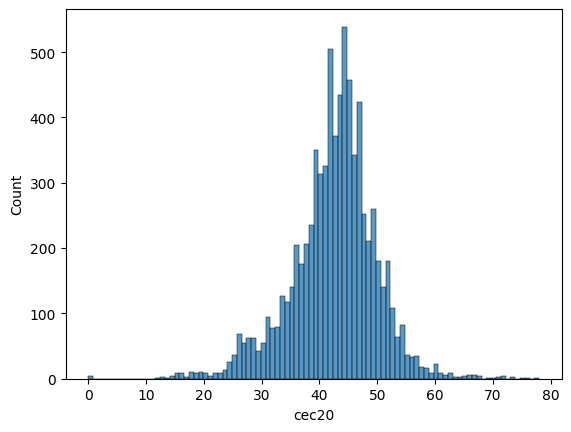

In [577]:
sns.histplot(train["cec20"])

Plotting: 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]


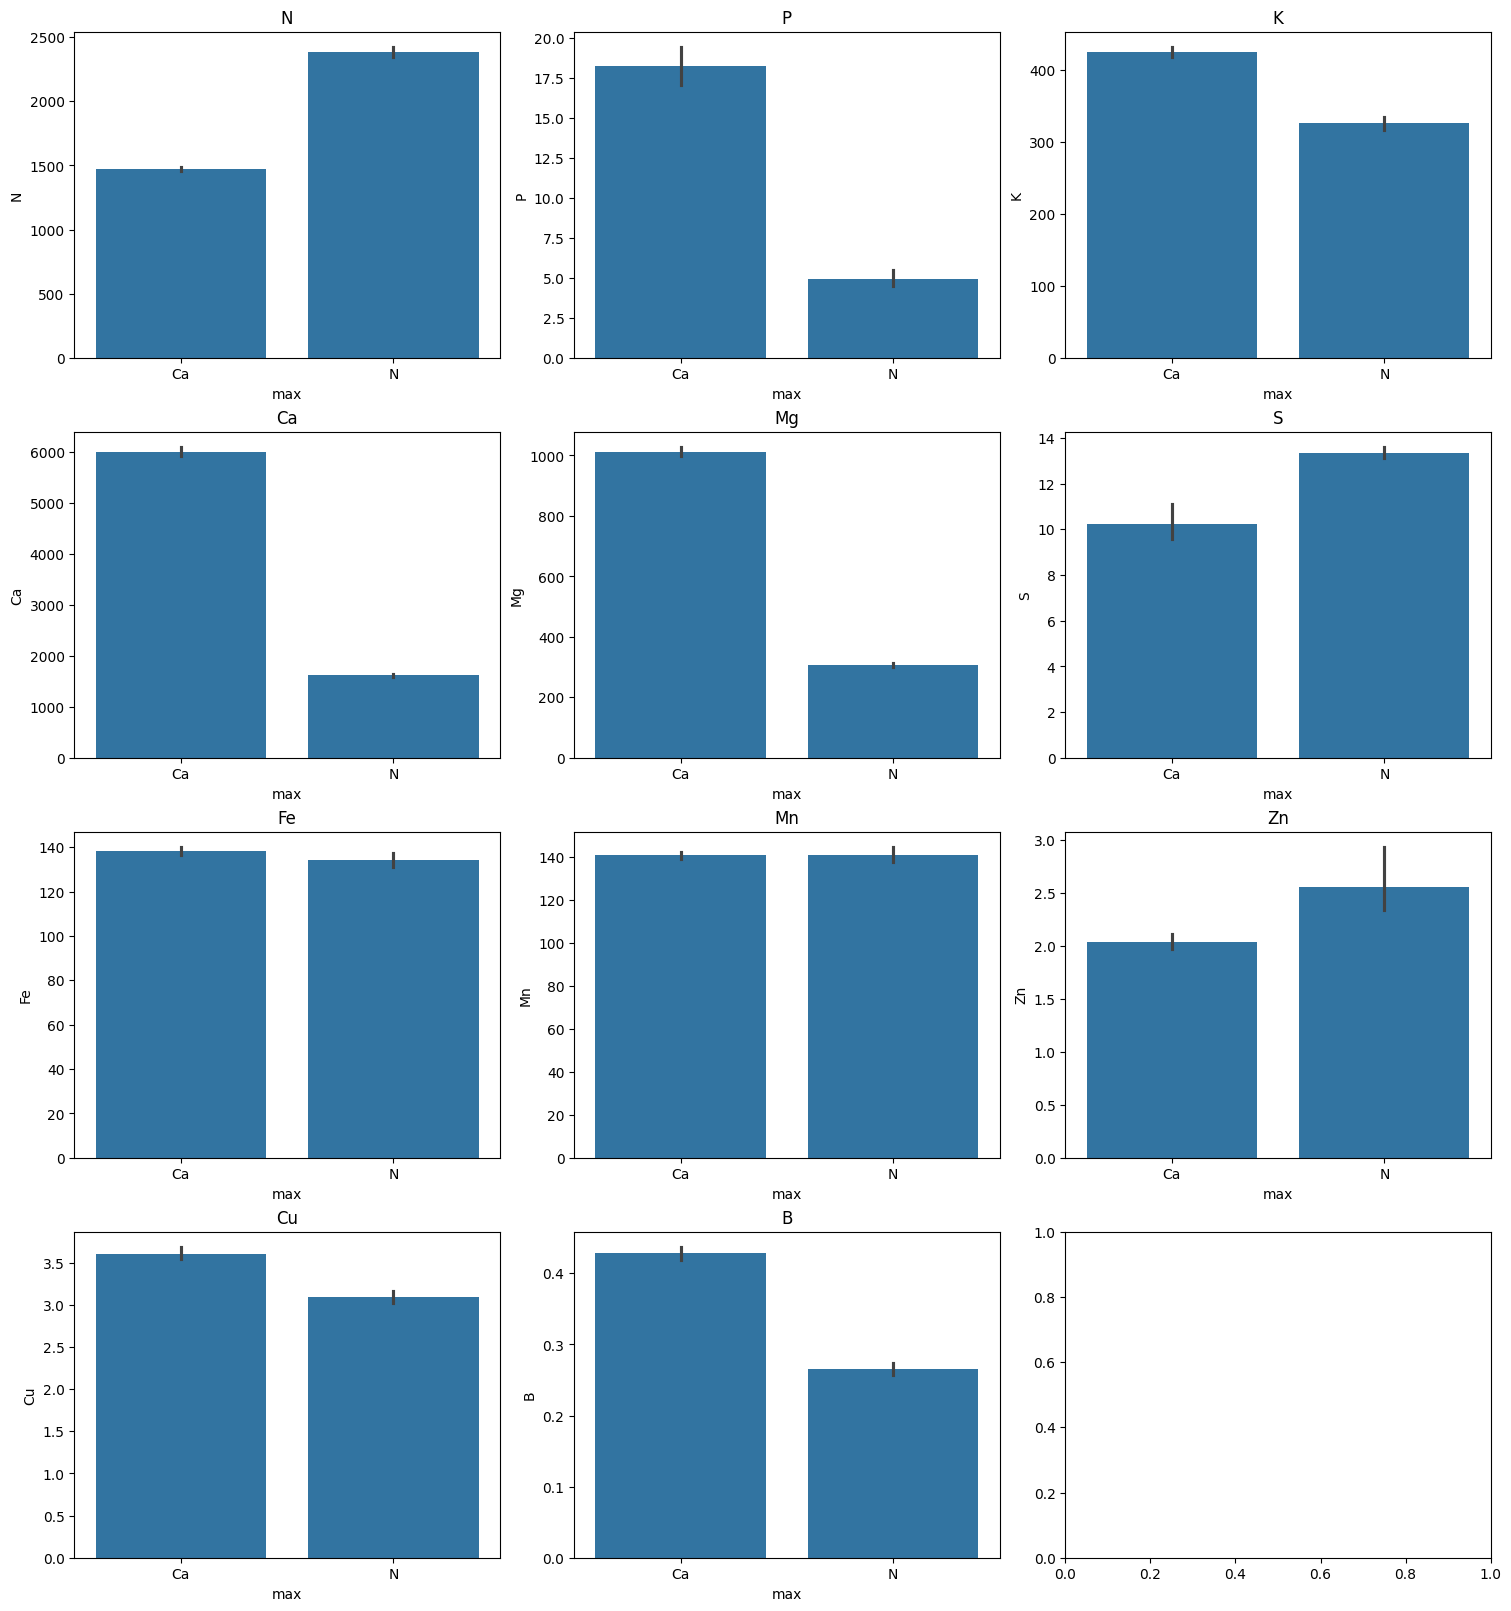

In [488]:
column_count = len(target_columns)
nrows = (column_count + 2) // 3
ncols = min(column_count, 3)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(5*ncols, 4*nrows),
                        constrained_layout=True)
axs = axs.reshape(-1)
for i, col in enumerate(tqdm(target_columns, desc="Plotting")):
    axs[i].set_title(col)
    sns.barplot(x=train_t['max'], y=train_dropna[col], ax=axs[i])
plt.show()

In [362]:
from xgboost import XGBRegressor
xgb = Pipeline([drop_step, ("xgb", (
    TransformedTargetRegressor(regressor=XGBRegressor(
        random_state=0,
        n_estimators=300,
        max_depth=10,
        learning_rate=0.025,
        subsample=0.6,
        tree_method='gpu_hist',
        predictor='gpu_predictor'),
        transformer=StandardScaler())))])
eval_model(xgb, X, Y, n_jobs=-1, n_splits=4, estimator_key="xgb")

mean score: 594.9640734590919
median score: 590.9687621462806
std: 14.396417981299216
scores:   [594.91776164 587.01976266 579.80229524 618.11647431]
mean degraded
median degraded


{'fit_time': array([251.37510228, 248.76393509, 251.12820029, 252.96539283]),
 'score_time': array([0.2880888 , 0.57800412, 0.23379111, 0.1587503 ]),
 'test_score': array([-594.91776164, -587.01976266, -579.80229524, -618.11647431])}

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "xgb__regressor__n_estimators": [100, 250, 500],
    "xgb__regressor__max_depth": [3, 5, 10],
    "xgb__regressor__learning_rate": [0.01, 0.1, 0.3],
    "xgb__regressor__subsample": [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    verbose=1
)

grid_search.fit(X, Y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'xgb__regressor__learning_rate': 0.01, 'xgb__regressor__max_depth': 10, 'xgb__regressor__n_estimators': 500, 'xgb__regressor__subsample': 0.6}
Best score: 216414.928125


In [356]:

param_grid = {
    "hist__estimator__regressor__max_iter": [300],
    "hist__estimator__regressor__learning_rate": [0.1],
    "hist__estimator__regressor__min_samples_leaf": [10, 15, 20, 25, 30],
}

grid_search_hist = GridSearchCV(
    estimator=hist,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search_hist.fit(X, Y)

print("Best parameters:", grid_search_hist.best_params_)
print("Best score:", -grid_search_hist.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'hist__estimator__regressor__learning_rate': 0.1, 'hist__estimator__regressor__max_iter': 300, 'hist__estimator__regressor__min_samples_leaf': 20}
Best score: 222318.53496575216


In [13]:
target_score = {}
for target in tqdm(target_columns):
    print(target)
    m = Y[target].mean()
    h = Pipeline([drop_step, cluster_step,
                  ("hist", HistGradientBoostingRegressor(random_state=0))])
    r = eval_model(h, X, Y[target].values, n_jobs=-1, estimator_key=target)
    scores = -r['test_score']
    mean_ = np.mean(scores)
    target_score[target] = (mean_,  mean_/m)
    print(target_score[target])

  0%|          | 0/11 [00:00<?, ?it/s]

N


  9%|▉         | 1/11 [00:07<01:11,  7.11s/it]

mean score: 885.9682168985142
median score: 884.5654740768233
std: 16.526249362466775
scores:   [876.59454248 861.10173583 884.56547408 900.45791355 907.12141856]
first evaluation
(np.float64(885.9682168985142), np.float64(0.5363149373694673))
P


 18%|█▊        | 2/11 [00:11<00:50,  5.64s/it]

mean score: 38.960558602019326
median score: 38.32391858341182
std: 2.7894162731315726
scores:   [36.14538451 39.6506845  36.71621544 43.96658997 38.32391858]
first evaluation
(np.float64(38.960558602019326), np.float64(2.498430362425205))
K


 27%|██▋       | 3/11 [00:15<00:39,  4.92s/it]

mean score: 308.4990817180081
median score: 305.9392791338762
std: 9.001880959307774
scores:   [305.93927913 295.46842513 304.58873396 321.66907205 314.82989832]
first evaluation
(np.float64(308.4990817180081), np.float64(0.7620474711862001))
Ca


 36%|███▋      | 4/11 [00:19<00:31,  4.49s/it]

mean score: 2359.688811520246
median score: 2317.0955812214897
std: 122.81098610406066
scores:   [2218.01454518 2473.89613827 2317.09558122 2256.82512694 2532.61266599]
first evaluation
(np.float64(2359.688811520246), np.float64(0.4600480972808728))
Mg


 45%|████▌     | 5/11 [00:23<00:25,  4.28s/it]

mean score: 523.3367781628092
median score: 526.143438161684
std: 7.356491538006047
scores:   [511.5478667  526.14343816 518.74559546 527.82827755 532.41871295]
first evaluation
(np.float64(523.3367781628092), np.float64(0.6002154096459078))
S


 55%|█████▍    | 6/11 [00:26<00:19,  3.94s/it]

mean score: 9.526423197936879
median score: 9.717538075503318
std: 0.9249635110046284
scores:   [ 9.71753808  8.51289262  8.42933559 10.77614958 10.19620011]
first evaluation
(np.float64(9.526423197936879), np.float64(0.8776010220100515))
Fe


 64%|██████▎   | 7/11 [00:30<00:15,  3.79s/it]

mean score: 75.62602311187166
median score: 76.17916243388261
std: 1.017066465757656
scores:   [74.18201415 74.66378402 76.28981718 76.81533777 76.17916243]
first evaluation
(np.float64(75.62602311187166), np.float64(0.5498950227142632))
Mn


 73%|███████▎  | 8/11 [00:33<00:10,  3.62s/it]

mean score: 96.06327181873235
median score: 96.01792649685513
std: 1.4342928244440911
scores:   [95.29573677 96.69457119 98.3081037  94.00002093 96.0179265 ]
first evaluation
(np.float64(96.06327181873235), np.float64(0.6817633167992053))
Zn


 82%|████████▏ | 9/11 [00:36<00:06,  3.43s/it]

mean score: 2.568428550772882
median score: 2.524478261799121
std: 0.07542745396147675
scores:   [2.48376737 2.68467983 2.52447826 2.6282585  2.52095879]
first evaluation
(np.float64(2.568428550772882), np.float64(1.1996161357933501))
Cu


 91%|█████████ | 10/11 [00:39<00:03,  3.36s/it]

mean score: 2.4070152861993073
median score: 2.407128681194389
std: 0.06153074291900232
scores:   [2.38305812 2.40772829 2.40712868 2.32348025 2.51368109]
first evaluation
(np.float64(2.4070152861993073), np.float64(0.6869769287330234))
B


100%|██████████| 11/11 [00:42<00:00,  3.89s/it]

mean score: 0.34102066964008404
median score: 0.3482378548107798
std: 0.014701998319678838
scores:   [0.33728945 0.34823785 0.31390787 0.3523259  0.35334227]
first evaluation
(np.float64(0.34102066964008404), np.float64(0.861771008417802))


In [111]:
t = pd.DataFrame({"Variable": target_score.keys(),
                 "RMSE": target_score.values()})
t['RMSE normalized'] = t["RMSE"].map(lambda x: x[1])
t['RMSE'] = t["RMSE"].map(lambda x: x[0])
t = t.sort_values(by=["RMSE normalized", "RMSE"], ascending=False)
t

,Variable,RMSE,RMSE normalized
1,P,38.960559,2.498430
8,Zn,2.568429,1.199616
5,S,9.526423,0.877601
10,B,0.341021,0.861771
2,K,308.499082,0.762047
9,Cu,2.407015,0.686977
7,Mn,96.063272,0.681763
4,Mg,523.336778,0.600215
6,Fe,75.626023,0.549895
0,N,885.968217,0.536315


In [363]:
xgb.fit(X, Y)

Pipeline(steps=[('drop',
                 FunctionTransformer(func=<function <lambda> at 0x000001687AE75300>)),
                ('xgb',
                 TransformedTargetRegressor(regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_typ...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.025,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=10,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=300,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...),
                                            transformer=StandardScaler()))])

In [364]:
predictions = predict(xgb, test)
predictions.to_csv("submissions/xgb_submission.csv", index=False)
predictions.head()

,ID,Gap
0,ID_NGS9Bx_N,-3173.261328
1,ID_YdVKXw_N,-3263.888105
2,ID_MZAlfE_N,-2859.639153
3,ID_GwCCMN_N,-3678.720952
4,ID_K8sowf_N,-3808.742407


In [17]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hist, X, Y, n_repeats=1, random_state=0)
importance = result.importances_mean

print("Feature importances:", importance)

Feature importances: [0.00000000e+00 0.00000000e+00 4.84507280e-02 5.70399062e-02
 3.48985919e-01 8.63117891e-03 7.04266398e-03 1.92684242e-02
 1.37937373e-02 1.20965179e-02 2.38485392e-02 7.87906619e-03
 1.04825584e-02 7.35431042e-03 5.87831467e-03 3.92609588e-03
 1.48467762e-02 1.53313843e-02 1.06315964e-02 2.73208142e-02
 1.27806360e-02 9.28590882e-03 1.37011465e-02 5.00541880e-03
 1.06207115e-02 1.61308670e-02 1.92243965e-02 2.55997184e-02
 2.72816152e-02 1.48619291e-02 6.70060636e-03 4.66255508e-03
 4.88362948e-03 2.92771288e-02 1.30270081e-04 3.50919736e-03
 3.49776969e-03 5.09095683e-03 7.15644496e-03 1.44219450e-02
 1.72432704e-02 1.28226283e-02 9.43491174e-03 5.79149034e-03
 1.08277672e-02 5.27470571e-03 1.03430957e-02 3.93952684e-03
 5.55418122e-03 7.05801259e-03 4.43876806e-03 6.46692433e-03
 4.82896165e-03 6.14808878e-03 1.70881418e-02 7.75874474e-03
 6.25011269e-03 3.50893453e-03 8.31827726e-03 1.66831280e-02
 6.06060459e-03 4.35317115e-03 6.10695890e-03 5.44413488e-03
 1.

In [18]:
f_i = pd.DataFrame({"F": X.columns, "I": importance}


                   ).sort_values(by="I", ascending=False)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', None):
    print(f_i)

                            F         I
4                          pH  0.348986
3                         lat  0.057040
67                         VH  0.049107
2                         lon  0.048451
33                   QA_PIXEL  0.029277
19                        mb2  0.027321
28                      soc20  0.027282
27                      snd20  0.025600
82    CLOUDY_PIXEL_PERCENTAGE  0.025209
10                         bp  0.023849
84    NODATA_PIXEL_PERCENTAGE  0.023462
7                       bio12  0.019268
26                      slope  0.019224
40                      SR_B6  0.017243
54                LST_Day_1km  0.017088
59                SolarZenith  0.016683
25                       ph20  0.016131
64             sur_refl_b07.1  0.015589
17                       lstn  0.015331
83    MEAN_SOLAR_ZENITH_ANGLE  0.014940
29                        tim  0.014862
16                       lstd  0.014847
68                         VV  0.014725
39                      SR_B5  0.014422


In [19]:
# Initialize variables correctly
columns = X.columns.difference(["PID", "site", "BulkDensity"])
result = eval_model(hist, X, Y, n_jobs=-1, print_result=False)
scores = -result['test_score']
base_mean = np.mean(scores)

# Initialize DataFrame to store scores
score_results = pd.DataFrame(columns=["column", "score", "difference"])
columns_to_drop = []

print(f"Base score: {base_mean:.4f}")

for column in tqdm(columns, desc="Evaluating columns"):

    try:
        # Drop only the current column being evaluated (not accumulated columns_to_drop)
        X_col = X.drop(columns=[column])

        # Evaluate model without this column
        r = eval_model(hist, X_col, Y, n_jobs=-1, print_result=False)
        current_scores = -r['test_score']  # Note: using r, not result
        current_mean = np.mean(current_scores)
        diff = current_mean - base_mean

        # Store results
        score_results.loc[len(score_results)] = [column, current_mean, diff]

        # Decision logic (fixed comparison)
        if current_mean <= base_mean:  # Better or equal performance without this column
            columns_to_drop.append(column)
            print(f"{column} can be dropped (Δ: {diff:.4f})")
        else:
            print(f"{column} is important (Δ: {diff:.4f})")
    except:
        print(f"error testing column {column}")

# Final results
print("\nColumns to drop:", columns_to_drop)
print("\nScore summary:")
print(score_results.sort_values("difference", ascending=False))

Base score: 603.2022


Evaluating columns:   1%|          | 1/83 [00:28<38:29, 28.16s/it]

B1 is important (Δ: 4.7802)


Evaluating columns:   2%|▏         | 2/83 [00:58<39:48, 29.49s/it]

B11 is important (Δ: 2.2208)


Evaluating columns:   4%|▎         | 3/83 [01:39<46:07, 34.60s/it]

B12 is important (Δ: 3.1733)


Evaluating columns:   5%|▍         | 4/83 [02:08<42:37, 32.37s/it]

B2 is important (Δ: 3.6845)


Evaluating columns:   6%|▌         | 5/83 [02:40<41:53, 32.22s/it]

B3 is important (Δ: 2.1051)


Evaluating columns:   7%|▋         | 6/83 [03:16<43:11, 33.65s/it]

B4 is important (Δ: 2.1943)


Evaluating columns:   8%|▊         | 7/83 [03:52<43:32, 34.37s/it]

B5 is important (Δ: 3.2507)


Evaluating columns:  10%|▉         | 8/83 [04:24<42:00, 33.61s/it]

B6 is important (Δ: 2.8412)


Evaluating columns:  11%|█         | 9/83 [04:53<39:51, 32.32s/it]

B7 is important (Δ: 2.6356)


Evaluating columns:  12%|█▏        | 10/83 [05:22<37:55, 31.17s/it]

B8 is important (Δ: 3.4809)


Evaluating columns:  13%|█▎        | 11/83 [05:50<36:05, 30.08s/it]

B8A is important (Δ: 1.3963)


Evaluating columns:  14%|█▍        | 12/83 [06:19<35:30, 30.01s/it]

B9 is important (Δ: 3.5330)


Evaluating columns:  16%|█▌        | 13/83 [06:47<34:00, 29.15s/it]

CLOUDY_PIXEL_PERCENTAGE is important (Δ: 3.7437)


Evaluating columns:  17%|█▋        | 14/83 [07:16<33:43, 29.33s/it]

ET is important (Δ: 2.5156)


Evaluating columns:  18%|█▊        | 15/83 [07:45<33:10, 29.27s/it]

EVI is important (Δ: 2.5282)


Evaluating columns:  19%|█▉        | 16/83 [08:14<32:34, 29.17s/it]

LST_Day_1km is important (Δ: 3.1961)


Evaluating columns:  20%|██        | 17/83 [08:44<32:16, 29.35s/it]

LST_Night_1km is important (Δ: 1.9567)


Evaluating columns:  22%|██▏       | 18/83 [09:15<32:19, 29.84s/it]

MEAN_SOLAR_ZENITH_ANGLE is important (Δ: 2.8819)


Evaluating columns:  23%|██▎       | 19/83 [09:45<31:48, 29.83s/it]

NDVI is important (Δ: 2.2282)


Evaluating columns:  24%|██▍       | 20/83 [10:14<30:55, 29.45s/it]

NODATA_PIXEL_PERCENTAGE is important (Δ: 2.6274)


Evaluating columns:  25%|██▌       | 21/83 [10:42<30:07, 29.15s/it]

Nadir_Reflectance_Band1 is important (Δ: 3.9800)


Evaluating columns:  27%|██▋       | 22/83 [11:08<28:39, 28.19s/it]

Nadir_Reflectance_Band2 is important (Δ: 0.9526)


Evaluating columns:  28%|██▊       | 23/83 [11:32<27:05, 27.09s/it]

Nadir_Reflectance_Band3 is important (Δ: 2.1250)


Evaluating columns:  29%|██▉       | 24/83 [11:59<26:29, 26.95s/it]

Nadir_Reflectance_Band4 can be dropped (Δ: -0.3505)


Evaluating columns:  30%|███       | 25/83 [12:23<25:17, 26.17s/it]

PET is important (Δ: 1.8269)


Evaluating columns:  31%|███▏      | 26/83 [12:48<24:31, 25.81s/it]

QA_PIXEL is important (Δ: 1.9899)


Evaluating columns:  33%|███▎      | 27/83 [13:15<24:20, 26.07s/it]

QA_RADSAT is important (Δ: 1.0674)


Evaluating columns:  34%|███▎      | 28/83 [13:43<24:28, 26.71s/it]

RelativeAzimuth is important (Δ: 1.9185)


Evaluating columns:  35%|███▍      | 29/83 [14:11<24:20, 27.04s/it]

SENSING_ORBIT_NUMBER is important (Δ: 0.9034)


Evaluating columns:  36%|███▌      | 30/83 [14:42<24:52, 28.16s/it]

SR_B1 is important (Δ: 0.8570)


Evaluating columns:  37%|███▋      | 31/83 [15:06<23:28, 27.09s/it]

SR_B2 can be dropped (Δ: -0.1221)


Evaluating columns:  39%|███▊      | 32/83 [15:30<22:08, 26.06s/it]

SR_B3 is important (Δ: 3.6282)


Evaluating columns:  40%|███▉      | 33/83 [15:55<21:19, 25.59s/it]

SR_B4 is important (Δ: 1.3467)


Evaluating columns:  41%|████      | 34/83 [16:20<20:44, 25.40s/it]

SR_B5 is important (Δ: 3.2103)


Evaluating columns:  42%|████▏     | 35/83 [16:44<20:04, 25.10s/it]

SR_B6 is important (Δ: 1.0280)


Evaluating columns:  43%|████▎     | 36/83 [17:09<19:39, 25.09s/it]

SR_B7 is important (Δ: 3.4932)


Evaluating columns:  45%|████▍     | 37/83 [17:34<19:09, 24.98s/it]

ST_B10 is important (Δ: 2.3285)


Evaluating columns:  46%|████▌     | 38/83 [17:58<18:37, 24.84s/it]

SolarZenith is important (Δ: 0.2257)


Evaluating columns:  47%|████▋     | 39/83 [18:24<18:20, 25.01s/it]

VH is important (Δ: 2.4775)


Evaluating columns:  48%|████▊     | 40/83 [18:48<17:41, 24.69s/it]

VV is important (Δ: 4.2202)


Evaluating columns:  49%|████▉     | 41/83 [19:10<16:53, 24.14s/it]

ViewZenith is important (Δ: 1.7895)


Evaluating columns:  51%|█████     | 42/83 [19:32<15:59, 23.39s/it]

alb is important (Δ: 3.1421)


Evaluating columns:  52%|█████▏    | 43/83 [19:53<15:08, 22.72s/it]

bio1 is important (Δ: 3.2146)


Evaluating columns:  53%|█████▎    | 44/83 [20:15<14:31, 22.34s/it]

bio12 is important (Δ: 5.3243)


Evaluating columns:  54%|█████▍    | 45/83 [20:36<13:57, 22.03s/it]

bio15 is important (Δ: 3.7805)


Evaluating columns:  55%|█████▌    | 46/83 [20:57<13:26, 21.79s/it]

bio7 is important (Δ: 1.8513)


Evaluating columns:  57%|█████▋    | 47/83 [21:19<13:03, 21.78s/it]

bp is important (Δ: 3.7620)


Evaluating columns:  58%|█████▊    | 48/83 [21:40<12:38, 21.69s/it]

cec20 is important (Δ: 3.5889)


Evaluating columns:  59%|█████▉    | 49/83 [22:01<12:08, 21.43s/it]

dows is important (Δ: 4.5838)


Evaluating columns:  60%|██████    | 50/83 [22:23<11:45, 21.39s/it]

ecec20 is important (Δ: 1.0807)


Evaluating columns:  61%|██████▏   | 51/83 [22:44<11:24, 21.38s/it]

hp20 is important (Δ: 1.4287)


Evaluating columns:  63%|██████▎   | 52/83 [23:05<10:58, 21.26s/it]

lat is important (Δ: 1.6736)


Evaluating columns:  64%|██████▍   | 53/83 [23:30<11:10, 22.34s/it]

lon is important (Δ: 5.0268)


Evaluating columns:  65%|██████▌   | 54/83 [23:57<11:26, 23.69s/it]

ls is important (Δ: 2.0637)


Evaluating columns:  66%|██████▋   | 55/83 [24:21<11:09, 23.91s/it]

lstd is important (Δ: 4.2194)


Evaluating columns:  67%|██████▋   | 56/83 [24:47<11:01, 24.49s/it]

lstn is important (Δ: 0.9424)


Evaluating columns:  69%|██████▊   | 57/83 [25:11<10:36, 24.48s/it]

mb1 is important (Δ: 2.2577)


Evaluating columns:  70%|██████▉   | 58/83 [25:36<10:11, 24.47s/it]

mb2 is important (Δ: 3.1788)


Evaluating columns:  71%|███████   | 59/83 [26:00<09:46, 24.42s/it]

mb3 is important (Δ: 3.1074)


Evaluating columns:  72%|███████▏  | 60/83 [26:32<10:15, 26.76s/it]

mb7 is important (Δ: 1.6118)


Evaluating columns:  73%|███████▎  | 61/83 [27:06<10:33, 28.81s/it]

mdem is important (Δ: 1.9356)


Evaluating columns:  75%|███████▍  | 62/83 [27:40<10:35, 30.25s/it]

pH is important (Δ: 123.8911)


Evaluating columns:  76%|███████▌  | 63/83 [28:05<09:37, 28.89s/it]

para is important (Δ: 1.2159)


Evaluating columns:  77%|███████▋  | 64/83 [28:30<08:44, 27.63s/it]

parv is important (Δ: 4.4680)


Evaluating columns:  78%|███████▊  | 65/83 [28:55<08:02, 26.82s/it]

ph20 is important (Δ: 2.2257)


Evaluating columns:  80%|███████▉  | 66/83 [29:20<07:25, 26.18s/it]

relativeOrbitNumber_start is important (Δ: 0.9640)


Evaluating columns:  81%|████████  | 67/83 [29:44<06:48, 25.56s/it]

slope is important (Δ: 4.2199)


Evaluating columns:  82%|████████▏ | 68/83 [30:08<06:17, 25.18s/it]

snd20 is important (Δ: 3.6393)


Evaluating columns:  83%|████████▎ | 69/83 [30:32<05:49, 24.98s/it]

soc20 is important (Δ: 5.1466)


Evaluating columns:  84%|████████▍ | 70/83 [30:57<05:21, 24.73s/it]

sur_refl_b01 is important (Δ: 2.6569)


Evaluating columns:  86%|████████▌ | 71/83 [31:22<04:57, 24.83s/it]

sur_refl_b01.1 is important (Δ: 2.6315)


Evaluating columns:  87%|████████▋ | 72/83 [31:46<04:31, 24.67s/it]

sur_refl_b02 is important (Δ: 1.5887)


Evaluating columns:  88%|████████▊ | 73/83 [32:11<04:07, 24.74s/it]

sur_refl_b02.1 is important (Δ: 3.8267)


Evaluating columns:  89%|████████▉ | 74/83 [32:36<03:42, 24.75s/it]

sur_refl_b03 is important (Δ: 2.3421)


Evaluating columns:  90%|█████████ | 75/83 [32:58<03:11, 23.97s/it]

sur_refl_b03.1 is important (Δ: 3.4055)


Evaluating columns:  92%|█████████▏| 76/83 [33:20<02:43, 23.37s/it]

sur_refl_b04 is important (Δ: 1.4415)


Evaluating columns:  93%|█████████▎| 77/83 [33:41<02:16, 22.74s/it]

sur_refl_b05 is important (Δ: 1.7257)


Evaluating columns:  94%|█████████▍| 78/83 [34:02<01:50, 22.17s/it]

sur_refl_b06 is important (Δ: 1.6117)


Evaluating columns:  95%|█████████▌| 79/83 [34:23<01:27, 21.94s/it]

sur_refl_b07 is important (Δ: 1.3333)


Evaluating columns:  96%|█████████▋| 80/83 [34:44<01:04, 21.65s/it]

sur_refl_b07.1 is important (Δ: 3.2891)


Evaluating columns:  98%|█████████▊| 81/83 [35:10<00:45, 22.98s/it]

tim is important (Δ: 0.0909)


Evaluating columns:  99%|█████████▉| 82/83 [35:36<00:23, 23.68s/it]

wp is important (Δ: 4.1114)


Evaluating columns: 100%|██████████| 83/83 [36:00<00:00, 26.03s/it]

xhp20 is important (Δ: 2.8055)

Columns to drop: ['Nadir_Reflectance_Band4', 'SR_B2']

Score summary:
                     column       score  difference
61                       pH  727.093321  123.891095
43                    bio12  608.526529    5.324303
68                    soc20  608.348793    5.146566
52                      lon  608.229070    5.026843
0                        B1  607.982462    4.780236
..                      ...         ...         ...
29                    SR_B1  604.059268    0.857042
37              SolarZenith  603.427897    0.225670
80                      tim  603.293096    0.090869
30                    SR_B2  603.080079   -0.122147
23  Nadir_Reflectance_Band4  602.851715   -0.350511

[83 rows x 3 columns]


In [28]:

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', None):
    print(score_results.sort_values(by="difference"))

                       column       score  difference
23    Nadir_Reflectance_Band4  602.851715   -0.350511
30                      SR_B2  603.080079   -0.122147
80                        tim  603.293096    0.090869
37                SolarZenith  603.427897    0.225670
29                      SR_B1  604.059268    0.857042
28       SENSING_ORBIT_NUMBER  604.105657    0.903430
55                       lstn  604.144626    0.942400
21    Nadir_Reflectance_Band2  604.154814    0.952588
65  relativeOrbitNumber_start  604.166210    0.963983
34                      SR_B6  604.230189    1.027963
26                  QA_RADSAT  604.269667    1.067440
49                     ecec20  604.282922    1.080695
62                       para  604.418164    1.215937
78               sur_refl_b07  604.535481    1.333255
32                      SR_B4  604.548895    1.346668
10                        B8A  604.598529    1.396303
50                       hp20  604.630924    1.428697
75               sur_refl_b0

In [32]:
print(list(score_results['column'][score_results["difference"] <= 1.5]))

['B8A', 'Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band4', 'QA_RADSAT', 'SENSING_ORBIT_NUMBER', 'SR_B1', 'SR_B2', 'SR_B4', 'SR_B6', 'SolarZenith', 'ecec20', 'hp20', 'lstn', 'para', 'relativeOrbitNumber_start', 'sur_refl_b04', 'sur_refl_b07', 'tim']


Plotting distributions: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


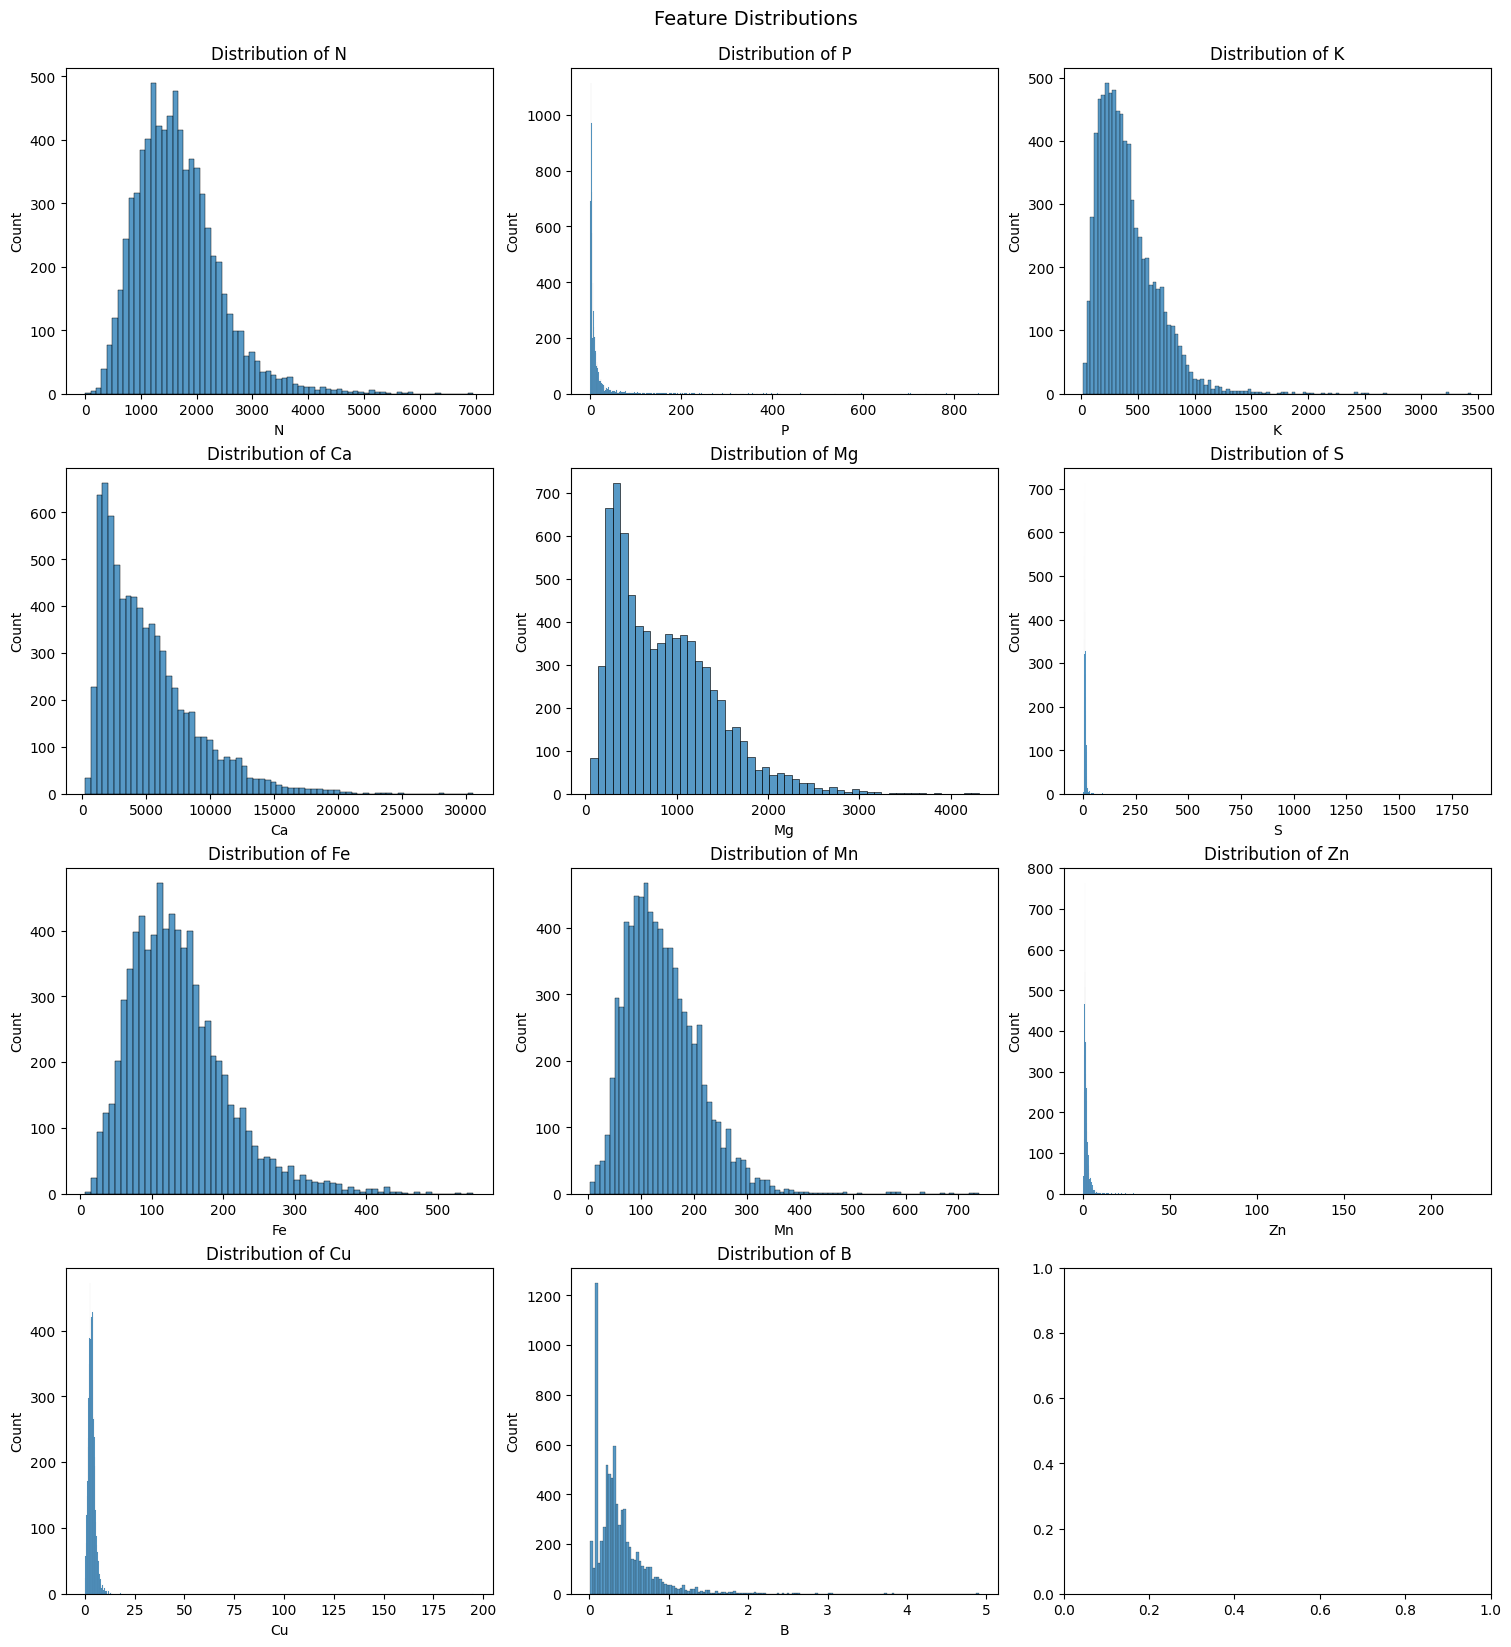

In [33]:
column_count = len(target_columns)
nrows = (column_count + 2) // 3
ncols = min(column_count, 3)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(5*ncols, 4*nrows),
                        constrained_layout=True)
axs = axs.reshape(-1)
for i, col in enumerate(tqdm(target_columns, desc="Plotting distributions")):

    axs[i].set_title(f"Distribution of {col}")
    sns.histplot(train[col], ax=axs[i])
plt.suptitle("Feature Distributions", y=1.02, fontsize=14)
plt.show()

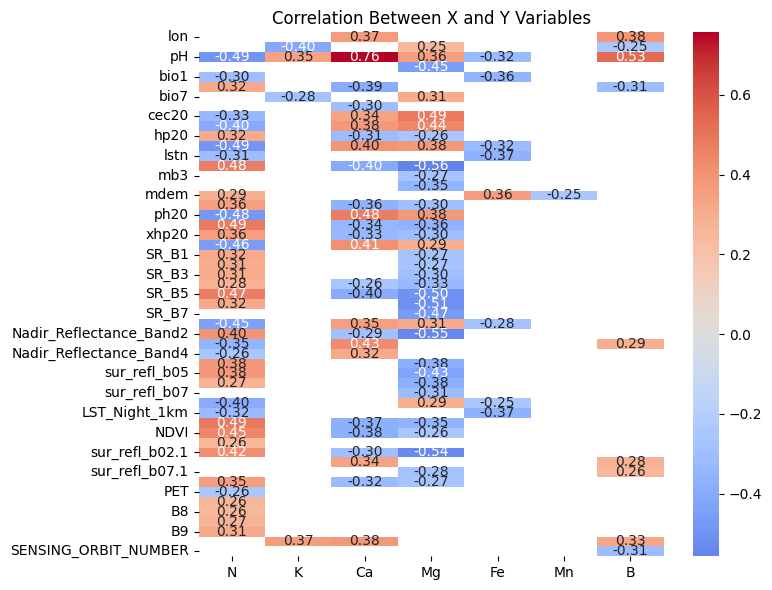

In [63]:


# Compute full correlation matrix
corr_matrix = train.select_dtypes(include="number").corr()

# Extract only correlations between X columns and Y columns
corr_X_Y = corr_matrix.loc[X.select_dtypes(
    include="number").columns, Y.columns]
corr_X_Y = corr_X_Y[np.abs(corr_X_Y) >= 0.25]
corr_X_Y.drop(
    columns=corr_X_Y.columns[corr_X_Y.isna().all(axis=0)], inplace=True)
corr_X_Y.drop(
    corr_X_Y.index[corr_X_Y.isna().all(axis=1)], inplace=True)
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_X_Y, annot=True, fmt=".2f",
            cmap="coolwarm", center=0)
plt.title("Correlation Between X and Y Variables")
plt.tight_layout()
plt.show()